## This Project: Screenshot to FEN

Purpose:
To be able to take a screenshot of a chess board and to convert the image to a positional characterisation in FEN (see https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation for a short description of the notation).

The first section of this notebook involves creating a robust CNN model to detect pieces from their individual squares. Using this (https://www.kaggle.com/koryakinp/chess-positions) kaggle dataset we get a wide variety of board colours and textures to challenge our model.

In the second section, we apply the trained model to some screenshots from some tactics I have played on chess.com. We have used open cvs library to be able to find the board placement in the image and extract/ resize it for our model.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from sklearn.metrics import confusion_matrix

## Functions for pre/post-processing FEN and Images

In [2]:
# setting image and square shape parameters

img_width, img_height = 400, 400    
square_width = img_width // 8
square_height = img_height // 8
border_crop_px = 2
sq_wdth = square_width - 2*border_crop_px
sq_hgt = square_height - 2*border_crop_px

In [3]:
def square_extractor(img):
# taking our board image, splitting it into squares and then removing a 2px border 400x400x3 => 64x46x46x3

    # splitting image into 8 equal rows
    rows = [img[i-square_height:i,:,:] for i in np.arange(square_height, img_height + square_height, square_height)] 
    # splitting individual rows into squares
    squares = [j[:,i-square_width:i,:] for j in rows for i in np.arange(square_width, img_width + square_width, square_width)]
    # cropping 2 pixels off each 50x50 image to get rid of the square borders
    squares = [i[border_crop_px:square_height-border_crop_px, border_crop_px:square_width-border_crop_px,:] for i in squares]   
    
    return squares

In [4]:
def load_preprocess_square_images(img):
# reading our board image, sending back an RGB image of each square (with 2px edge crop) on the board that has blur 
# returning matrix of shape => 64x46x46x3

    img = cv2.imread(img,3)
    img = cv2.resize(img, (img_width,img_height))
    img = cv2.blur(img,(3,3)) # applying blur to smooth our noise
    img = np.float32(img) / 255.0 # To keep the image values between 0 and 1 for our CNN
    squares = square_extractor(img)
    
    return squares

In [5]:
def space_characterizor(rank):
# using our FEN notation to create an 1x8 chess row matrix, mainting FEN notation for pieces    
    
    broken_pieces = [i for i in rank] # splitting the row into individual char/ elems
    
    for i, j in enumerate(broken_pieces):
        try:
            broken_pieces[i] = 'o' * int(j) # as ints denote empty spaces we replace the int by that no of 'o'
        except:
            continue
            
    rank = ''.join(broken_pieces) # joining all our text to create a 8 character row        

    return rank

In [6]:
def fen_to_numeric(all_fen):  
# creating labels for each FEN piece notation

    piece_numeric = {'o':0,'p':1,'b':2,'r':3,'n':4,'k':5,'q':6,'P':7,'B':8,'R':9,'N':10,'K':11,'Q':12}
    broken_fen = re.split(r'-/?', all_fen) # splitting our fen into rows
    broken_rows = [space_characterizor(i) for i in broken_fen] # creating a 8x8 board matrix from each row
    # replacing each character with its equivalent number and flattening to a 1x64 vector
    fen_board = [piece_numeric[str(i)] for i in np.array([list(j) for j in broken_rows]).flatten()]
    
    return np.array(fen_board)

In [7]:
def get_key(val): 
# function to extract piece from number in our assigned dictionary
    
    piece_numeric = {'o':0,'p':1,'b':2,'r':3,'n':4,'k':5,'q':6,'P':7,'B':8,'R':9,'N':10,'K':11,'Q':12}
    for key, value in piece_numeric.items(): 
         if val == value: 
            return key 

In [8]:
def char_2_fen(rows, white = True):
# replacing 'o' (empty squares) with their corresponding number of occurences in int format
# then assembling with an '/' joining rows and adding the requirements needed to input into chess.com
# such as whether it is white or black's turn to play, a variable called for in the function

    for indy, i in enumerate(rows):
        for indx, j in enumerate(i):
            if j == 'o':
                counter = 0
                for k in range(8-indx):
                    if rows[indy][indx + k] == 'o':
                        counter += 1
                        rows[indy][indx + k] = ''
                    else:
                        break
                rows[indy][indx + counter - 1] = str(counter)
                
    fen = '/'.join([''.join(row_elem) for row_elem in rows])
    fen_ending = '- - 0 1' # now for adding the end notation to make it readable for chess websites
    
    if white == True:
        next_play = ' w '
    else:
        next_play = ' b '

    fen = fen + next_play + fen_ending

    return fen

## Loading our dataset: 

### Google Collab

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
train_set = Path("/content/drive/My Drive/Project_Jedha/test")

In [17]:
all_image_paths = [str(img_path) for img_path in train_set.glob("*.jpeg")]
print(all_image_paths[:5])
all_image_fen = [re.search(r'test/(.*?).jpeg',i).group(1) for i in all_image_paths]
print(all_image_fen[:5])

['/content/drive/My Drive/Project_Jedha/test/n3n3-7N-2r1Nn2-PN6-K1n3N1-2k5-6qN-n7.jpeg', '/content/drive/My Drive/Project_Jedha/test/RR3k2-1K3p2-3q1q2-1q6-8-8-Q7-3nR1Q1.jpeg', '/content/drive/My Drive/Project_Jedha/test/Rb5n-1p6-5N2-N7-2k5-K7-8-1N2n3.jpeg', '/content/drive/My Drive/Project_Jedha/test/b5B1-1b6-1N1NPB2-2B1R3-1r4kN-4K1P1-8-8.jpeg', '/content/drive/My Drive/Project_Jedha/test/n1Qb1r2-4k3-5n2-4P3-8-5P2-8-qK6.jpeg']
['n3n3-7N-2r1Nn2-PN6-K1n3N1-2k5-6qN-n7', 'RR3k2-1K3p2-3q1q2-1q6-8-8-Q7-3nR1Q1', 'Rb5n-1p6-5N2-N7-2k5-K7-8-1N2n3', 'b5B1-1b6-1N1NPB2-2B1R3-1r4kN-4K1P1-8-8', 'n1Qb1r2-4k3-5n2-4P3-8-5P2-8-qK6']


### Local

In [9]:
train_set = Path(r"C:\Users\alecp\Desktop\FINAL_PROJECT\Datasets\train")

In [10]:
all_image_paths = [str(img_path) for img_path in train_set.glob("*.jpeg")]
print(f'path: {all_image_paths[0]}')
all_image_fen = [re.search(r'train\\(.*?).jpeg',i).group(1) for i in all_image_paths]
print(f'board FEN: {all_image_fen[0]}')

path: C:\Users\alecp\Desktop\FINAL_PROJECT\Datasets\train\1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg
board FEN: 1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3


## Piece prediction feature engineering

In [12]:
sample_size = 200

In [13]:
# creating our target variable from the fen in shape = (sample_size * 64, 1)
target = np.array([fen_to_numeric(i) for i in all_image_fen[:sample_size]]).flatten()
print(f'target (FEN) shape 64*{sample_size}: {target.shape}')
# creating our squares of shape sample_sizex64x46x46x3
squares = [load_preprocess_square_images(i) for i in all_image_paths[:sample_size]]
print(f'RGB squares of {sq_hgt}x{sq_wdth}, dataset shape: ({sample_size}, {np.array(squares[0]).shape}')

target (FEN) shape 64*200: (12800,)
RGB squares of 46x46, dataset shape: (200, (64, 46, 46, 3)


In [14]:
# reshaping to place into dataframe with shape = (64*sample_size, 46*46*3)
squares = tf.reshape(squares, (-1, (sq_hgt*sq_wdth*3)))
print(f'resized "flattened" squares shape {sample_size}*64, {sq_hgt}*{sq_wdth}*3: {squares.shape}')

resized "flattened" squares shape 200*64, 46*46*3: (12800, 6348)


In [15]:
# very unbalanced dataset with many more empty squares than filled ones, removing at random a large proportion of these.
drop_ds = pd.DataFrame([target, squares]).transpose().rename({0: 'target', 1: 'squares'}, axis = 1)

print(f'pre drop:\n{drop_ds.target.value_counts()[:5]}')
print(f'original size = {squares.shape[0]}')

n_drop = drop_ds.target.value_counts()[0] - drop_ds.target.value_counts()[1] - (sample_size * 2)
to_remove = np.random.choice(drop_ds[drop_ds.target == 0].index,size=n_drop,replace=False)
drop_ds = drop_ds.drop(to_remove)

print('----------')
print(f'post drop:\n{drop_ds.target.value_counts()[:5]}')
print(f'new size = {len(drop_ds.target)}')

pre drop:
0    10450
2      326
8      288
4      235
7      206
Name: target, dtype: int64
original size = 12800
----------
post drop:
0    583
2    326
8    288
4    235
7    206
Name: target, dtype: int64
new size = 2933


In [16]:
target = drop_ds.target.values # taking our filtered target out of the dataframe
# taking our squares out of the dataframe and reshaping them to (64*reduced_sample_size, 46, 46, 3)
squares = [drop_ds.squares.iloc[i] for i in range(len(drop_ds.squares))]
squares = tf.reshape(squares, (-1, 46, 46, 3))

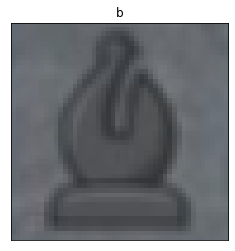

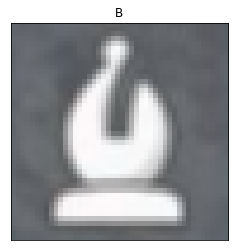

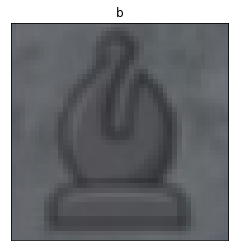

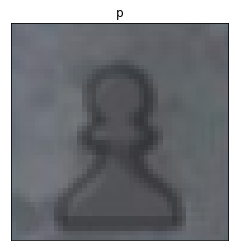

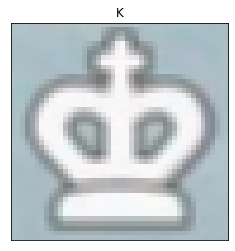

In [17]:
a = np.arange(5)
for i in a:
    plt.imshow(tf.squeeze(squares[i]), cmap = 'gray', filternorm = False)
    plt.title(get_key(target[i]))
    plt.xticks(())
    plt.yticks(())
    plt.show()

## Now onto our CNN modelling

In [18]:
new_size = squares.shape[0]
BATCH_SIZE = 64
TRAIN_SIZE = 0.8
SPLIT = int((new_size // BATCH_SIZE) * TRAIN_SIZE)

tf_ds = tf.data.Dataset.from_tensor_slices((squares, np.float32(target)))
tf_ds = tf_ds.shuffle(new_size).batch(BATCH_SIZE)

train = tf_ds.take(SPLIT)
test = tf_ds.skip(SPLIT)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[46, 46, 3]),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=13, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0

In [21]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)

initial_lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = new_size,
    decay_rate = 0.90,
    staircase = True
)

optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule)

model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics = 'sparse_categorical_accuracy')

In [22]:
EPOCHS = 10
history = model.fit(train, epochs = EPOCHS, validation_data = test)

Epoch 1/10
36/36 [==============================] - 59s 2s/step - loss: 2.4851 - sparse_categorical_accuracy: 0.1649 - val_loss: 2.3908 - val_sparse_categorical_accuracy: 0.2067
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 2.3231 - sparse_categorical_accuracy: 0.2374 - val_loss: 1.9659 - val_sparse_categorical_accuracy: 0.3100
Epoch 3/10
36/36 [==============================] - 58s 2s/step - loss: 1.7297 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.3967 - val_sparse_categorical_accuracy: 0.4833
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 1.1772 - sparse_categorical_accuracy: 0.6098 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.7949
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.6240 - sparse_categorical_accuracy: 0.7938 - val_loss: 0.3475 - val_sparse_categorical_accuracy: 0.8649
Epoch 6/10
36/36 [==============================] - 60s 2s/step - loss: 0.4289 - sparse_categorical_accuracy: 

In [23]:
# to visualise the training process our model has undertaken we use it's history to plot some line graphs
histories = [i for i in history.history.keys()]
loss = history.history[histories[0]]
sparse_cat_acc = history.history[histories[1]]
val_loss = history.history[histories[2]]
val_sparse_cat_acc = history.history[histories[3]]

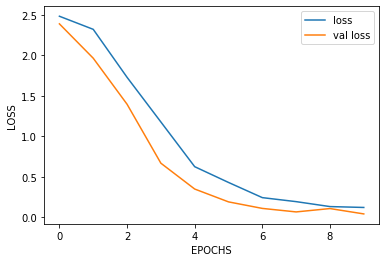

In [24]:
plt.plot(range(EPOCHS), loss, label = 'loss')
plt.plot(range(EPOCHS), val_loss, label = 'val loss')
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.show()

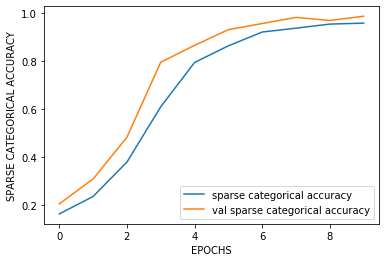

In [25]:
plt.plot(range(EPOCHS), sparse_cat_acc, label = 'sparse categorical accuracy')
plt.plot(range(EPOCHS), val_sparse_cat_acc, label = 'val sparse categorical accuracy')
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('SPARSE CATEGORICAL ACCURACY')
plt.show()

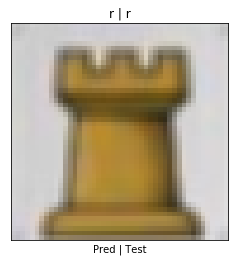

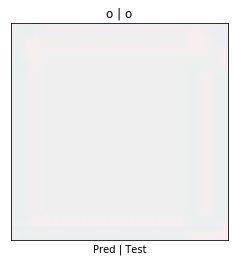

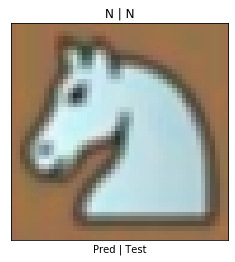

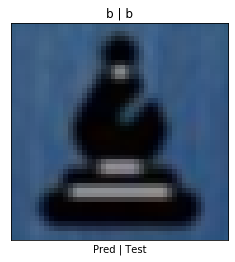

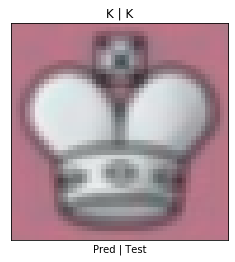

In [26]:
# testing our predictions with the notation: pred | real
for i, tar in test.take(1):
    y_pred = model.predict(i)
    for j in range(5):
        plt.imshow(tf.squeeze(i[j,:,:,:]))
        plt.title(get_key(np.argmax(y_pred[j])) + ' | ' + get_key(tar[j]))
        plt.xticks(())
        plt.yticks(())
        plt.xlabel('Pred | Test')
        plt.show()

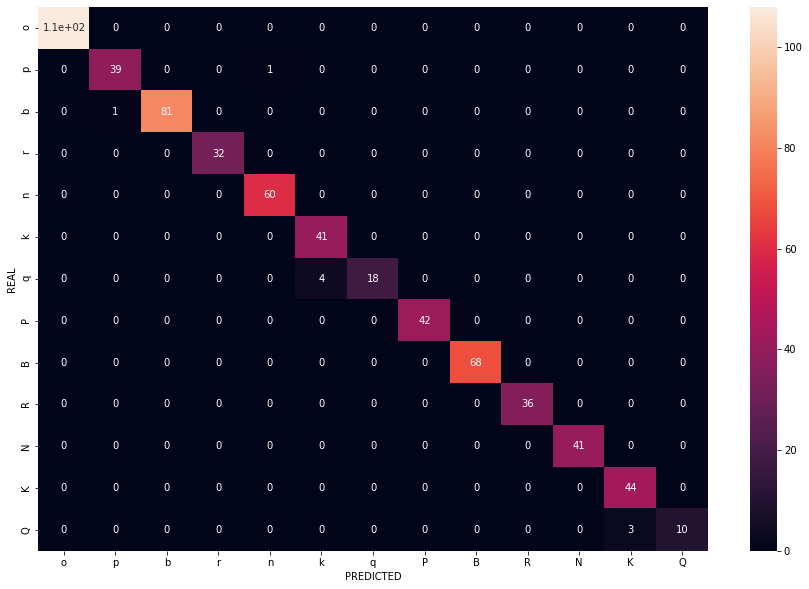

In [27]:
# plotting a confusion matrix for our test results
y_real = []
y_pred = []
for sq, targ in test.take((new_size // BATCH_SIZE) - SPLIT + 1):
    y_real.extend(targ.numpy().flatten())
    y_predy = [np.argmax(i) for i in model.predict(sq)]
    y_pred.extend(np.array(y_predy).flatten())

cm = confusion_matrix(y_real, y_pred, labels = range(13))

labels = [get_key(i) for i in range(13)]
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot = True)
plt.xticks(np.arange(.5,13.5,1),labels)
plt.yticks(np.arange(0.5,13.5,1),labels)
plt.ylabel('REAL')
plt.xlabel('PREDICTED')
# adding to avoid top and bottom cropping from the jupyter notebook
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) 
plt.show()

In [28]:
diag = np.diag((list(np.ones((1,13), dtype = int)[0])))
diff = cm.sum().sum() - (cm * diag).sum().sum()
accuracy = 1 - (diff / cm.sum().sum())
print(f' test size: {cm.sum().sum()},\n different results between test and pred: {diff},'
      f'\n accuracy: {np.round(accuracy * 100, 2)}%')

 test size: 629,
 different results between test and pred: 9,
 accuracy: 98.57%


## Saving and importing the Model from collab

In [44]:
#!mkdir -p BEST_MODEL
#model.save('BEST_MODEL/my_model.h5') 

In [ ]:
#!zip -r /content/file.zip /content/BEST_MODEL

In [ ]:
#from google.colab import files
#files.download("/content/file.zip")

## Loading BEST MODEL trained on collab

In [29]:
new_model = tf.keras.models.load_model(r'C:\Users\alecp\Desktop\FINAL_PROJECT\BEST_MODEL\my_model.h5')

In [30]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0

In [31]:
loss, acc = new_model.evaluate(test, verbose=2)

10/10 - 5s - loss: 3.7904e-10 - sparse_categorical_accuracy: 1.0000


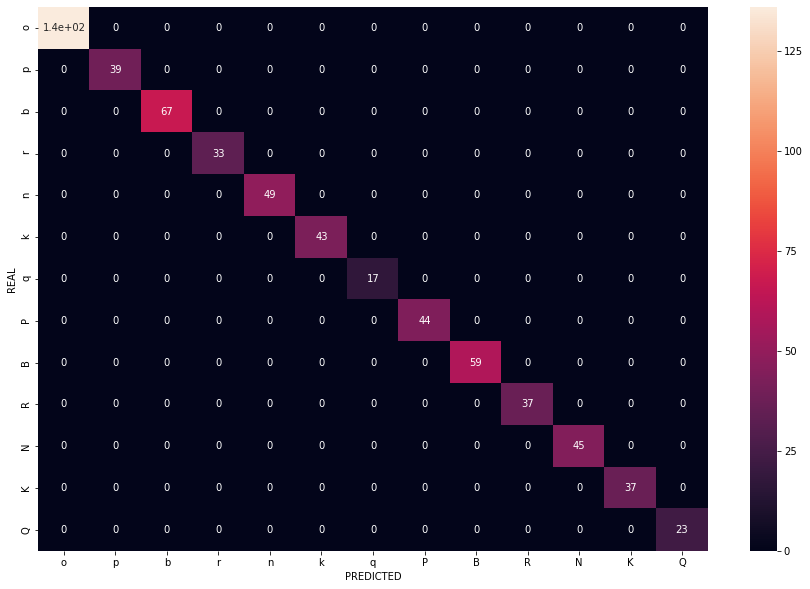

In [33]:
# plotting a confusion matrix for our test results
y_real = []
y_pred = []
for sq, targ in test.take((new_size // BATCH_SIZE) - SPLIT + 1):
    y_real.extend(targ.numpy().flatten())
    y_predy = [np.argmax(i) for i in new_model.predict(sq)]
    y_pred.extend(np.array(y_predy).flatten())

cm = confusion_matrix(y_real, y_pred, labels = range(13))

labels = [get_key(i) for i in range(13)]
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot = True)
plt.xticks(np.arange(.5,13.5,1),labels)
plt.yticks(np.arange(0.5,13.5,1),labels)
plt.ylabel('REAL')
plt.xlabel('PREDICTED')
# adding to avoid top and bottom cropping from the jupyter notebook
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) 
plt.show()

## Now for a example from the test set

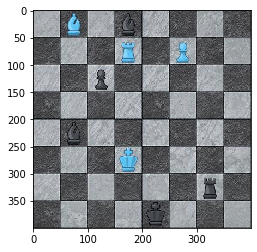

In [34]:
example = 40
plt.imshow(cv2.imread(all_image_paths[example]))

In [35]:
target = all_image_fen[example] # find target variable of e.g
squares = tf.expand_dims(load_preprocess_square_images(all_image_paths[example]), 1) # creating squares
ex_ds = tf.data.Dataset.from_tensor_slices(squares) # putting in a format our model can use
y_pred = new_model.predict(ex_ds) # predictions in probabilities (softmax)
y_pred_fen = [get_key(np.argmax(i)) for i in y_pred] # finding highest probability option
rows = [y_pred_fen[num - 8: num] for num in np.arange(8,72,8)] # splitting our 64 elem list into 8x8
pred_fen = char_2_fen(rows) # turning our 8x8 into corresponding FEN
print(f'predicted fen -> {pred_fen}')
print(f'real fen ------> {target}')

predicted fen -> 1B1b4/3R1P2/2p5/8/1b6/3K4/6r1/4k3 w - - 0 1
real fen ------> 1B1b4-3R1P2-2p5-8-1b6-3K4-6r1-4k3


## ONTO A REAL LIFE EXAMPLE

### FUNCTIONS TO EXTRACT BOARD SQUARES FROM SCREENSHOT

In [37]:
def board_finder(photo):
# a function to crop the board from a screenshot. Optimised for use with chess.com
# for other uses the threshold may need some tuning, THRESHOLD NOT SET TO CHANGE AUTOMATICALLY
    
    image = photo.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(image, 100, 255, 0)
    
    if (np.float32(cv2.__version__[0]) > 3): # adaptation for the version of open-cv in the notebook
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    else:
        im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) != 0:
        # find the 4 corners of the biggest countour (c) by the area i.e. our board
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
    
    img = photo[y:y+h,x:x+w] # crop it out of our first image to leave just the board
    img = cv2.resize(img, (400,400)) # resize for the next step in the processing
        
    return img

In [38]:
def load_preprocess_screenshot(img):
# reading our screenshot, cropping out the board and sending back an RGB of each square (with 2px edge crop) 
# on the board that has blur. Returning squares matrix of shape => 64x46x46x3

    img = cv2.imread(img,3)
    img = board_finder(img) # cropping the board and resizing to 400x400x3
    img = cv2.blur(img,(3,3)) # applying blur to smooth our noise
    img = np.float32(img) / 255.0 # To keep the image values between 0 and 1
    squares = square_extractor(img)
    
    return squares

### LOADING EXAMPLE SCREENSHOTS

In [39]:
example_root = Path(r'C:\Users\alecp\Desktop\FINAL_PROJECT\images\screenshot_test')
example_paths = [str(img_path) for img_path in example_root.glob("*.jpg")]
print(f'path example: {example_paths[0]}')
print(f'number of screenshots: {len(example_paths)}')

path example: C:\Users\alecp\Desktop\FINAL_PROJECT\images\screenshot_test\Screenshot_20200826_144148_com.chess.jpg
number of screenshots: 6


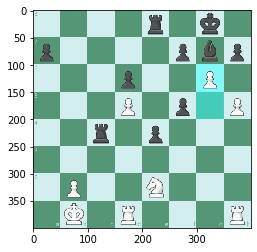

whose turn is it to play? (white / black) :black


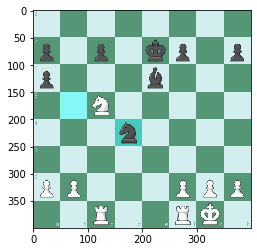

whose turn is it to play? (white / black) :white


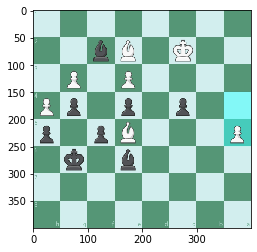

whose turn is it to play? (white / black) :black


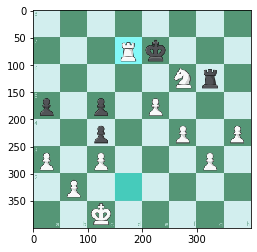

whose turn is it to play? (white / black) :black


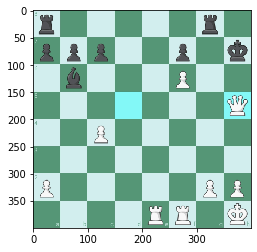

whose turn is it to play? (white / black) :black


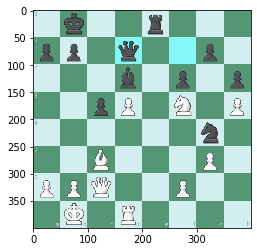

whose turn is it to play? (white / black) :white


In [40]:
turns = []
for i in example_paths:
    
    plt.imshow(board_finder(cv2.imread(i,3)))
    plt.show()
    choice = False
    while choice == False:
        turn = input('whose turn is it to play? (white / black) :').lower()
        if turn == 'black':
            white = False
            choice = True
        elif turn == 'white':
            white = True
            choice = True
        else:
            print('sorry there seems to have been a mistype, please retry...')
    turns.append(white)

image 0, FEN: 4r1k1/p4pbp/3p2P1/3P1p1P/2r1p3/8/1P2N3/1K1R3R b - - 0 1
image 1, FEN: 8/p1p1kp1p/p3b3/2N5/3n4/8/PP3PPP/2R2RK1 w - - 0 1
image 2, FEN: 8/2bB1K2/1P1P4/Pp1p1p2/p1pB3P/1k1b4/8/8 b - - 0 1
image 3, FEN: 8/3Rk3/5Nr1/p1p1P3/2p2P1P/P1P3P1/1P6/2K5 b - - 0 1
image 4, FEN: r5r1/ppp2p1k/1b3P2/7Q/2P5/8/P5PP/4RR1K b - - 0 1
image 5, FEN: 1k2r3/pp1q2p1/3b1p1p/2pP1N1P/6n1/2B3P1/PPQ2P2/1K1R4 w - - 0 1


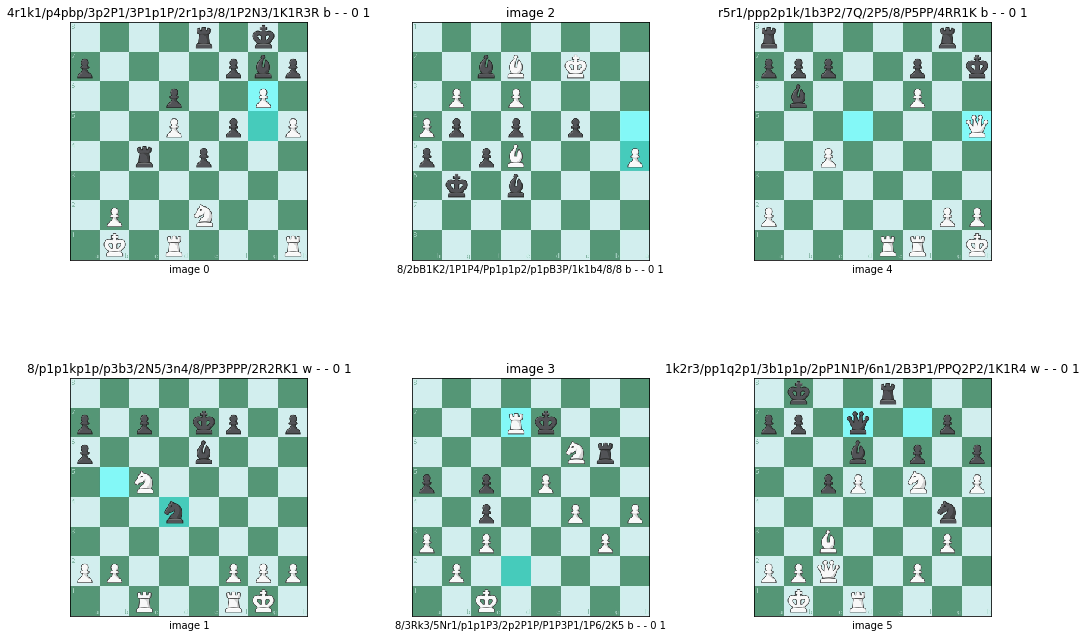

In [41]:
hor_sq = 3
vert_sq = 2

fig, axs = plt.subplots(vert_sq, hor_sq, figsize = (15,10))
for num, i in enumerate(example_paths): 

    squares = tf.expand_dims(load_preprocess_screenshot(i), 1)                   
    ex_ds = tf.data.Dataset.from_tensor_slices(squares)
    y_pred = new_model.predict(ex_ds)
    y_pred_fen = [get_key(np.argmax(i)) for i in y_pred]
    rows = [y_pred_fen[num - 8: num] for num in np.arange(8,72,8)] # splitting our 64 elem list into 8x8
    pred_fen = char_2_fen(rows, white = turns[num])
    print(f'image {num}, FEN: {pred_fen}')
    n, m = num%2, num//vert_sq 
    axs[n,m].imshow(board_finder(cv2.imread(i,3)))
    if m == 1:
        axs[n,m].set_title(f'image {num}')
        axs[n,m].set_xlabel(pred_fen)
    else:
        axs[n,m].set_title(pred_fen)
        axs[n,m].set_xlabel(f'image {num}')        
    axs[n,m].set_xticks(())
    axs[n,m].set_yticks(())
fig.tight_layout(pad = 0.8)
plt.show()

## DEMO

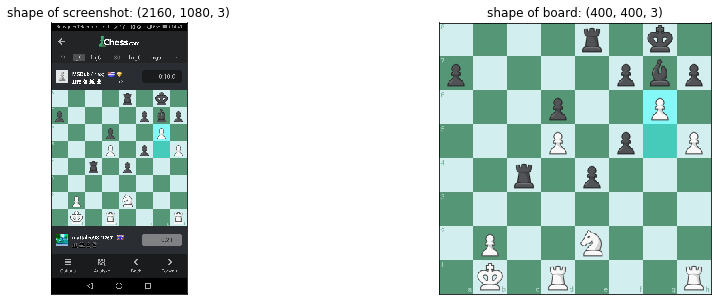

whose turn is it to play? (white / black) :black
predicted fen -> 4r1k1/p4pbp/3p2P1/3P1p1P/2r1p3/8/1P2N3/1K1R3R b - - 0 1


In [42]:
path_to_image = r"C:\Users\alecp\Desktop\FINAL_PROJECT\images\screenshot_test\Screenshot_20200826_144148_com.chess.jpg"

fig, axs = plt.subplots(1,2, figsize = (15,5))

photo = cv2.imread(path_to_image)
axs[0].imshow(photo)
axs[0].set_title(f'shape of screenshot: {photo.shape}')
axs[0].set_xticks(())
axs[0].set_yticks(())

board = board_finder(cv2.imread(path_to_image))
axs[1].imshow(board)
axs[1].set_title(f'shape of board: {board.shape}')
axs[1].set_xticks(())
axs[1].set_yticks(())

plt.show()

choice = False
while choice == False:
    turn = input('whose turn is it to play? (white / black) :').lower()
    if turn == 'black':
        white = False
        choice = True
    elif turn == 'white':
        white = True
        choice = True
    else:
        print('sorry there seems to have been a mistype, please retry...')
    
squares = tf.expand_dims(load_preprocess_screenshot(path_to_image), 1)                   
ex_ds = tf.data.Dataset.from_tensor_slices(squares)
y_pred = new_model.predict(ex_ds)
y_pred_fen = [get_key(np.argmax(i)) for i in y_pred]
rows = [y_pred_fen[num - 8: num] for num in np.arange(8,72,8)] # splitting our 64 elem list into 8x8
pred_fen = char_2_fen(rows, white = white)

print(f'predicted fen -> {pred_fen}')